In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import math

from glob import glob

%matplotlib inline

In [2]:
sns.set_style("whitegrid")
current_palette = sns.color_palette("muted")
sns.set_palette(current_palette)

In [3]:
def score(dataset, cutoffs):
    cols = [col for col in dataset.columns if (col not in ["name"] and "score" not in col)]
    for c in cutoffs:
        name = "score"+str(c)
        dataset[name] = dataset[dataset[cols] >= c][cols].fillna(0).sum(axis=1)

In [4]:
def gumbel(x, mi, beta):
    z = (x - mi) / beta
    return np.exp(-(z + np.exp(-z))) / beta

In [5]:
x = np.linspace(-1,4)
y = gumbel(x, 0.5, 0.5) + np.random.normal(0, 0.002, len(x))

(array([ 0.49990147,  0.49922287]),
 array([[  3.32032042e-07,   5.26769960e-08],
        [  5.26769960e-08,   2.29374350e-07]]))

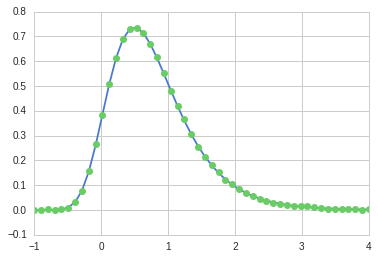

In [6]:
best_vals, covar = curve_fit(gumbel, x, y, p0=[0.0, 1.0])
y_fit = gumbel(x, *best_vals)
plt.plot(x, y_fit, '-')
plt.plot(x, y, 'o')
best_vals, covar

In [7]:
cutoffs = [i/10.0 for i in xrange(1,10)]
colnames = ["score"+str(i) for i in cutoffs]
cnum = len(cutoffs)

In [8]:
method = "DeCAF"
#method = "FP2"
#method = "FP3"
#method = "FP4"
#method = "MACCS"

In [9]:
all_data = pd.DataFrame(columns=["mol", "sample", "size", "cutoff", "score"])

In [10]:
k = 0
for i in glob("../data/statistical_model/results/" + method + "/*tab.bz2"):
    sample = i.split('/')[-1].split('.')[0]
    if k%10 == 0:
        print "processed", k, "samples"
    k += 1
    size = sample.split("_")[-1]
    dataset = pd.read_table(i, sep="\t")
    score(dataset, cutoffs)
    for j in xrange(cnum):
        tmp = dataset[["name", colnames[j]]]
        tmp.columns = ["mol", "score"]
        tmp["cutoff"] = cutoffs[j]
        tmp["size"] = size
        tmp["sample"] = sample
        all_data = pd.concat([all_data, tmp])
print "processed", k, "samples"

processed 0 samples
processed 10 samples
processed 20 samples
processed 30 samples
processed 40 samples
processed 50 samples
processed 60 samples
processed 70 samples
processed 80 samples
processed 90 samples
processed 100 samples


In [11]:
all_data["size"] = all_data["size"].astype(float)
all_data["score"] = all_data["score"].astype(float)
all_data["cutoff"] = all_data["cutoff"].astype(float)

In [12]:
all_data.head()

,cutoff,mol,sample,score,size
0,0.1,CHEMBL1302458,sample15_112,38.480759,112.0
1,0.1,CHEMBL117841,sample15_112,37.573140,112.0
2,0.1,CHEMBL2107656,sample15_112,37.260579,112.0
3,0.1,CHEMBL1797611,sample15_112,30.414708,112.0
4,0.1,CHEMBL1822085,sample15_112,39.069017,112.0


In [13]:
all_data.shape

(90000, 5)

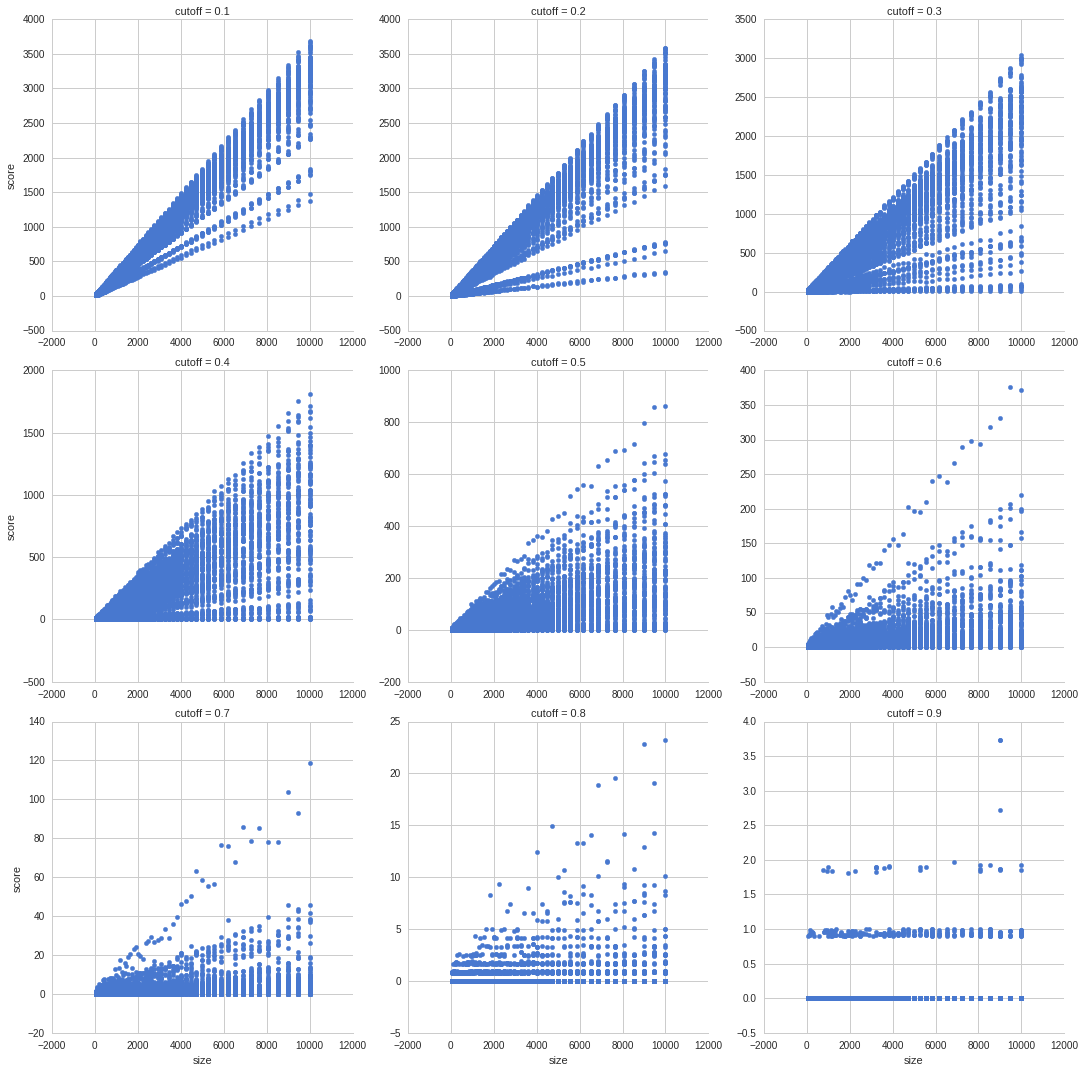

In [14]:
grid = sns.FacetGrid(all_data, col="cutoff", size=5, col_wrap=3, sharex=False, sharey=False, legend_out=True)
grid = (grid.map(plt.scatter, "size", "score").add_legend())
grid.savefig("../figures/supplementary/" + method + "_random_scores.pdf", bbox_inches="tight");

In [15]:
cutoff_groups = all_data.groupby(["cutoff", "size"])

In [16]:
means = cutoff_groups.mean()
means.reset_index(inplace=True)
means.head()

,cutoff,size,score
0,0.1,50.0,15.445165
1,0.1,53.0,15.829410
2,0.1,56.0,16.687823
3,0.1,59.0,17.650941
4,0.1,62.0,19.710357


In [17]:
stdev = cutoff_groups.std()
stdev.reset_index(inplace=True)
stdev.head()

,cutoff,size,score
0,0.1,50.0,2.611634
1,0.1,53.0,2.630311
2,0.1,56.0,2.660334
3,0.1,59.0,2.828681
4,0.1,62.0,3.467884


In [18]:
def raw_mean(x, a):
    return a*x

def raw_std(x, a, b):
    return a*(x**b)

In [19]:
params = {}

for c in cutoffs:
    params[c] = {}
    tmp = means[means["cutoff"] == c]
    x = tmp["size"]
    y = tmp["score"]
    best_vals, covar = curve_fit(raw_mean, x, y, p0=[1.0])
    y_fit = raw_mean(x, *best_vals)
    params[c]["mean"] = list(best_vals)

    tmp = stdev[stdev["cutoff"] == c]
    x = tmp["size"]
    y = tmp["score"]
    best_vals, covar = curve_fit(raw_std, x, y, p0=[1.0, 1.0])
    y_fit = raw_std(x, *best_vals)
    params[c]["std"] = list(best_vals)

In [20]:
params

{0.1: {'mean': [0.3035065020795763],
  'std': [0.050214502335033759, 0.99962620989490614]},
 0.2: {'mean': [0.27977805401292777],
  'std': [0.074298642611641472, 1.0000291938082739]},
 0.3: {'mean': [0.18959352107040828],
  'std': [0.082972588531225716, 0.99966150404296727]},
 0.4: {'mean': [0.079486310038848096],
  'std': [0.049298523375439829, 0.99780541353687091]},
 0.5: {'mean': [0.021056550791170109],
  'std': [0.019161502541326852, 0.9937496437888661]},
 0.6: {'mean': [0.0041835144217976517],
  'std': [0.0066156842870164446, 0.98268080551919035]},
 0.7: {'mean': [0.00072472935714567623],
  'std': [0.0020309056566072486, 0.95937705312207067]},
 0.8: {'mean': [0.00012597756061023655],
  'std': [0.0012474506946934694, 0.83806754772397296]},
 0.9: {'mean': [1.5209147355417976e-05],
  'std': [0.00088889839168464354, 0.66917105845627933]}}

In [21]:
f = open(("../data/statistical_model/" + method + ".params"), "w")
f.write(str(params))
f.close()

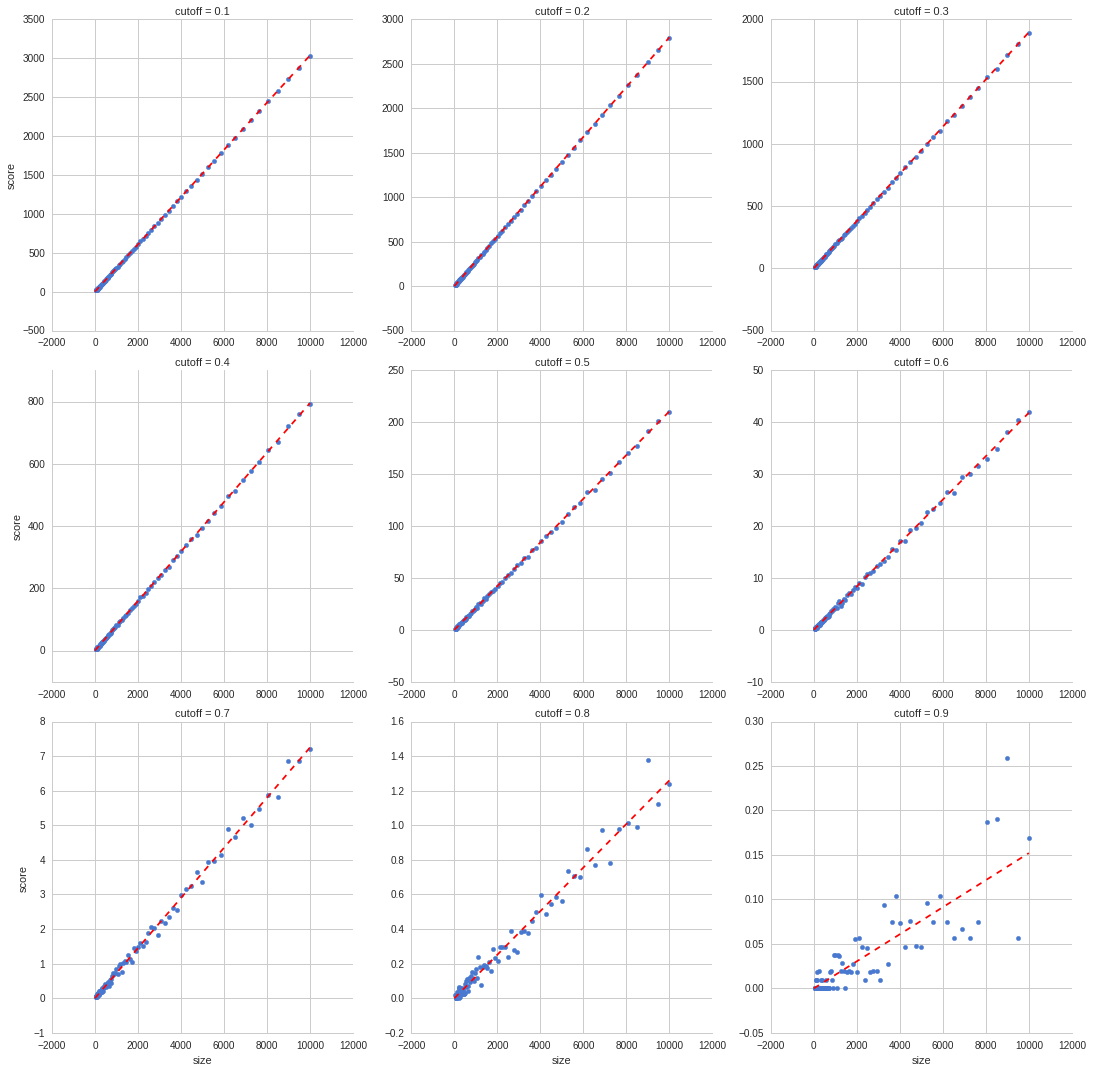

In [22]:
j = 0
grid_mean = sns.FacetGrid(means, col="cutoff", size=5, col_wrap=3, sharex=False, sharey=False, legend_out=True)
grid_mean = (grid_mean.map(plt.scatter, "size", "score").add_legend())
for ax in grid_mean.axes.flat:
    cutoff = cutoffs[j]
    x = np.linspace(0,10000)
    ax.plot(x, raw_mean(x, *params[cutoff]["mean"]), c="red", ls="--")
    j += 1
grid_mean.add_legend();
grid_mean.savefig("../figures/supplementary/" + method + "_random_mean.pdf", bbox_inches="tight")

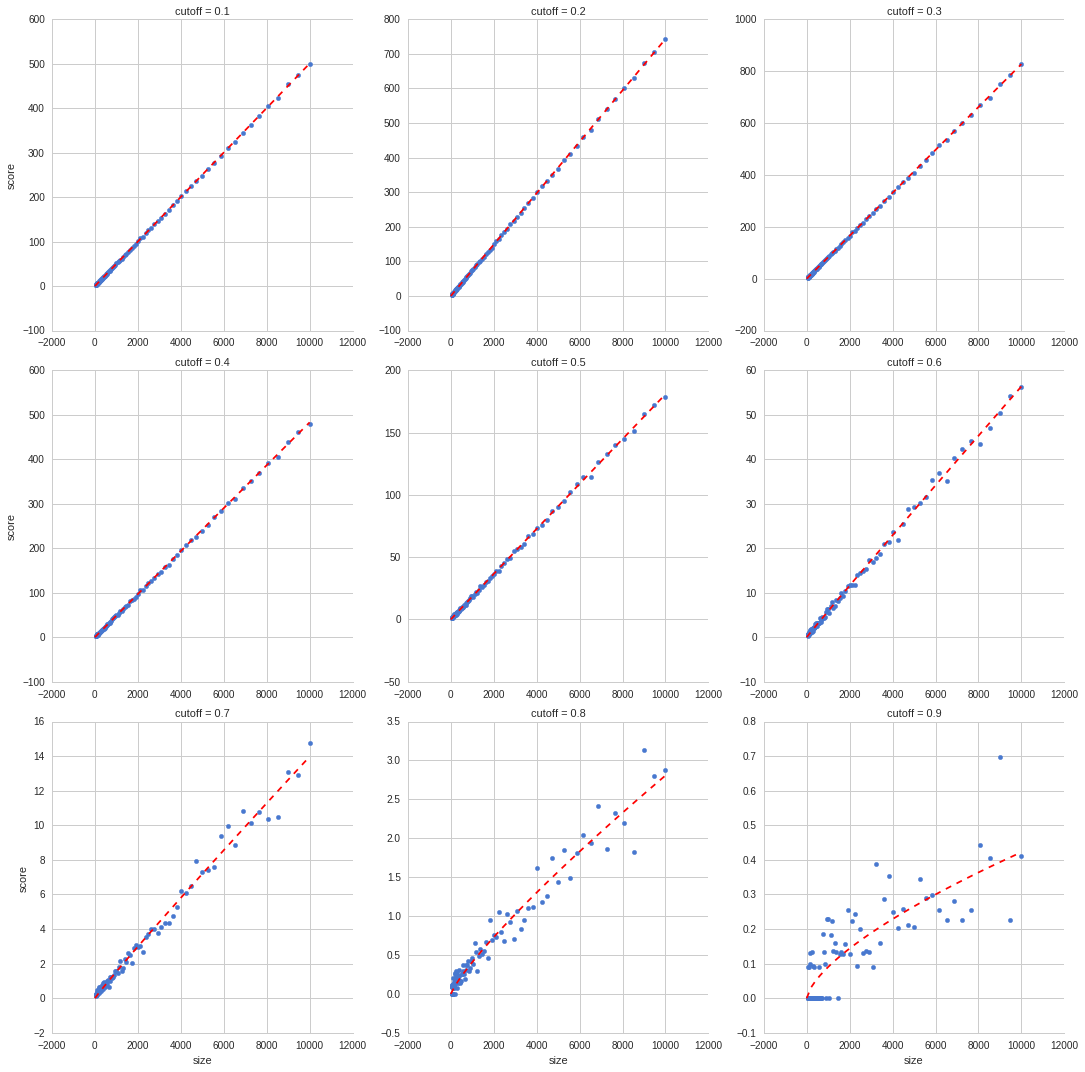

In [23]:
j = 0
grid_std = sns.FacetGrid(stdev, col="cutoff", size=5, col_wrap=3, sharex=False, sharey=False, legend_out=True)
grid_std = grid_std.map(plt.scatter, "size", "score")
for ax in grid_std.axes.flat:
    cutoff = cutoffs[j]
    x = np.linspace(0,10000)
    ax.plot(x, raw_std(x, *params[cutoff]["std"]), c="red", ls="--")
    j += 1
grid_std.add_legend();
grid_std.savefig("../figures/supplementary/" + method + "_random_sd.pdf", bbox_inches="tight")

In [24]:
def normalize(row):
    cutoff = row["cutoff"]
    size = row["size"]
    score = row["score"]
    z_score = ((row["score"] - raw_mean(size, *params[cutoff]["mean"])) / 
                raw_std(size, *params[cutoff]["std"]))
    return z_score

In [25]:
all_data["z_score"] = all_data.apply(normalize, axis=1)

In [26]:
np.mean(all_data["z_score"]), np.std(all_data["z_score"])

(0.0040451357622011538, 1.1402594563229425)

In [27]:
beta = math.sqrt(6.0) / math.pi
mi = -0.5772156649*beta

In [28]:
values = all_data["z_score"]
bins = np.arange(np.min(values), np.max(values), 1)
y_real, bin_edges = np.histogram(values, bins=bins)
y_real = y_real / float(len(values))
x = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

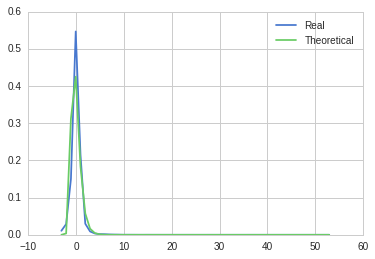

In [29]:
f, ax = plt.subplots()
ax.plot(x, y_real, label="Real")
ax.plot(x, gumbel(x, mi, beta), label="Theoretical")
ax.legend()
f.savefig("../figures/supplementary/" + method + "_fit.pdf", bbox_inches="tight");

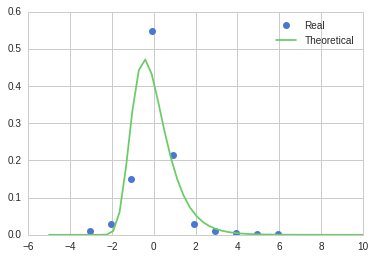

In [30]:
f, ax = plt.subplots()
ax.plot(x[:10], y_real[:10], 'o', label="Real")
x_smooth = np.linspace(-5, 10)
ax.plot(x_smooth, gumbel(x_smooth, mi, beta), label="Theoretical")
ax.legend()
f.savefig("../figures/supplementary/" + method + "_fit_notail.pdf", bbox_inches="tight");